In [1]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import simplekml
import fiona

In C:\Users\zande\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zande\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zande\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\zande\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zande\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
shape = fiona.open("inputs/tl_2019_48_tract/tl_2019_48_tract.shp")
d = {}
for s in shape:
    if s["properties"]["COUNTYFP"] == "453":
        d[s["properties"]["NAME"]] = s["geometry"]["coordinates"]

In [3]:
# Straight up grid
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

## Load in data

In [7]:
with open('inputs/austin_response_times.json') as f:
    austin_response_times = json.load(f)
    

In [11]:
ncalls = 100
calls = pd.read_csv("inputs/austin_test_calls.csv")
print(calls.head())


   interarrival_seconds  neighborhood  dow  stn1_min  stn2_min  stn3_min  \
0                    38            83  Wed    300.00   1619.74    647.46   
1                   537            38  Wed   1012.38   1580.48   1369.76   
2                    98           129  Wed   1291.87   2280.92   1335.77   
3                    18           107  Wed   2655.15   2258.48   2196.05   
4                   475           113  Wed    879.18   1770.93    923.08   

   stn4_min  stn5_min  stn6_min  stn7_min  ...  hosp3_min  hosp4_min  \
0    790.88    647.46    603.90   2503.11  ...    1152.23    1196.41   
1   1379.66   1369.76   1568.98   2946.06  ...    1826.82    1399.17   
2   1106.28   1335.77   1046.35   2601.02  ...     767.74    1857.59   
3   3050.22   2196.05   2764.35   1082.07  ...    2716.38    2120.80   
4    805.69    923.08    641.56   1977.15  ...     586.79    1444.90   

   hosp5_min  hosp6_min  hosp7_min  hosp8_min  hosp9_min  hosp10_min  \
0    2361.74    1371.38     603.90    

In [41]:
data = pd.DataFrame()
data['region_num'] = calls['neighborhood'][:ncalls]
data['response_time'] = austin_response_times['Robust005']['40']
print(data.head())

   region_num  response_time
0          83    1559.750000
1          38    1497.100000
2         129    1466.966667
3         107    2449.733333
4         113     300.000000


## Prepare data for heatmap using grid

In [42]:
# Using old distance matrix to get an idea of how close we are
with open("inputs/grid_info_smaller.json", "r") as f:
    grid_json = json.load(f)

In [43]:
g = Grid(grid_json)

In [44]:
data["census_tract"] = data.apply(lambda x: g.region_to_census_tract(x["region_num"]), axis=1)

In [47]:
data

,region_num,response_time,census_tract
0,83,1559.750000,"[3_06, 10, 9_01, 9_02, 21_08, 21_09, 23_04, 23..."
1,38,1497.100000,"[24_32, 24_35, 24_36]"
2,129,1466.966667,"[18_39, 18_48, 18_40, 18_41, 18_42, 18_24, 18_..."
3,107,2449.733333,"[17_68, 17_80, 17_64]"
4,113,300.000000,"[18_04, 18_11, 18_05, 18_13, 18_06, 18_12, 18_..."
...,...,...,...
95,142,722.350000,"[17_55, 17_82, 17_54, 17_56, 17_81, 17_85, 17_..."
96,66,1466.783333,"[20_03, 20_02, 20_05, 17_50, 20_04, 24_10, 24_..."
97,98,607.933333,"[18_11, 3_02, 18_12, 3_05, 3_04, 3_06, 3_07, 2..."
98,113,669.683333,"[18_04, 18_11, 18_05, 18_13, 18_06, 18_12, 18_..."


In [61]:
# Find unique census tracts
census_tract_list = data["census_tract"].to_numpy()
census_tract_list = census_tract_list.ravel()

flat_census_tract_list = []
for sublist in census_tract_list:
    for census_tract in sublist:
        flat_census_tract_list.append(census_tract)

#print(len(flat_census_tract_list))
print(np.unique(flat_census_tract_list))
print(len(np.unique(flat_census_tract_list)))

['10' '11' '12' '13_03' '13_04' '13_05' '13_07' '13_08' '14_01' '14_02'
 '14_03' '15_03' '15_04' '15_05' '16_02' '16_03' '16_04' '16_05' '16_06'
 '17_05' '17_06' '17_07' '17_12' '17_13' '17_14' '17_16' '17_22' '17_28'
 '17_29' '17_33' '17_37' '17_38' '17_40' '17_41' '17_42' '17_45' '17_46'
 '17_47' '17_48' '17_49' '17_50' '17_53' '17_54' '17_55' '17_56' '17_57'
 '17_60' '17_61' '17_64' '17_65' '17_68' '17_70' '17_71' '17_72' '17_73'
 '17_74' '17_75' '17_76' '17_77' '17_78' '17_80' '17_81' '17_82' '17_84'
 '17_85' '17_86' '18_04' '18_05' '18_06' '18_11' '18_12' '18_13' '18_17'
 '18_18' '18_19' '18_20' '18_21' '18_22' '18_23' '18_24' '18_26' '18_28'
 '18_29' '18_32' '18_33' '18_34' '18_35' '18_39' '18_40' '18_41' '18_42'
 '18_43' '18_44' '18_45' '18_46' '18_47' '18_48' '18_49' '18_50' '18_51'
 '18_55' '18_56' '18_57' '18_60' '18_61' '18_62' '18_63' '19_01' '19_10'
 '19_11' '19_12' '19_13' '19_14' '19_15' '19_17' '19_19' '1_01' '1_02'
 '20_02' '20_03' '20_04' '20_05' '21_04' '21_05' '21_0

## ignore

In [18]:
error = (data["transport_time"] - data["grid_time"])/(data["grid_time"])*100

Plot of the percent error in times (transport time - grid time)/(grid time)


<AxesSubplot:title={'center':'Percent Error'}, ylabel='Frequency'>

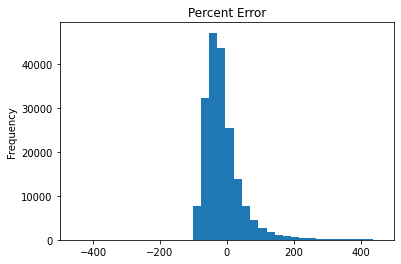

In [22]:
print("Plot of the percent error in times (transport time - grid time)/(grid time)")
error.plot.hist(bins=50000, xlim=(-500, 500), title="Percent Error")

In [25]:
# Filtering
errors = collections.defaultdict(int)
counts = collections.defaultdict(int)
for index, row in data.iterrows():
    for census_tract in row["census_tract"]:
        errors[census_tract] += (row["transport_time"]-row["grid_time"])
        counts[census_tract] += 1

for census_tract in errors:
    if counts[census_tract] > 50:
        errors[census_tract] /= counts[census_tract]
    else:
        errors[census_tract] = 0


## Create heatmaps

In [36]:
errors = collections.defaultdict(int)
counts = collections.defaultdict(int)
for index, row in data.iterrows():
    for census_tract in row["census_tract"]:
        #errors[census_tract] += (row["transport_time"]-row["grid_time"])
        errors[census_tract] += row['response_time']
        counts[census_tract] += 1

print(errors)
        
        
kml = simplekml.Kml(open=1)

# Gradient Plot
LATITUDE_DELTA = grid_json["latitude_step"]
LONGITUDE_DELTA = grid_json["longitude_step"]
min_error = min([e if e != 0 else float("inf") for e in errors.values()])
max_error = max(errors.values())
for census_tract in errors:
    if errors[census_tract] == 0:
        pol = kml.newpolygon(name="Tract: {}, Error: {}, Count: {}".format
                             (census_tract, ((errors[census_tract]*100)//1)/100, counts[census_tract]))
        pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
        pol.style.polystyle.color = "FFFFFFFF"
        continue
    pol = kml.newpolygon(name="Tract: {}, Error: {}%, Count: {}".format
                         (census_tract, int(((errors[census_tract]*100)//1)), counts[census_tract]))    
    pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
    color = int((errors[census_tract] - min_error)/(max_error-min_error)*511)
    if errors[census_tract] == 0:
        pol.style.polystyle.fill = 0
    elif color <= 255:
        pol.style.polystyle.color = "{:0>2}FF0000".format(hex((255-(-64)) - (color*(256-64)//256+64))[2:])
    elif color > 255:
        pol.style.polystyle.color = "{:0>2}0000FF".format(hex((color-256)*(256-64)//256+64)[2:])

kml.save("austin_simulation_response_time_heatmap.kml")

KeyError: 'census_tract'

In [572]:
# # Std
# errors = collections.defaultdict(list)
# for index, row in data.iterrows():
#     for census_tract in row["census_tract"]:
#         errors[census_tract].append(row["transport_time"] - row["grid_time"])

# for census_tract in errors:
#     errors[census_tract] = np.std(errors[census_tract])


In [573]:
# # L1
# errors = collections.defaultdict(int)
# counts = collections.defaultdict(int)
# for index, row in data.iterrows():
#     for census_tract in row["census_tract"]:
#         errors[census_tract] += abs(row["transport_time"] - row["grid_time"])
#         counts[census_tract] += 1
# for census_tract in errors:
#     errors[census_tract] /= counts[census_tract]

In [574]:
# # L1 divided mean
# errors = collections.defaultdict(int)
# counts = collections.defaultdict(int)
# transports = collections.defaultdict(int)
# for index, row in data.iterrows():
#     for census_tract in row["census_tract"]:
#         errors[census_tract] += abs(row["transport_time"] - row["grid_time"])
#         transports[census_tract] += row["transport_time"]
#         counts[census_tract] += 1
# for census_tract in errors:
#     errors[census_tract] /= counts[census_tract]
#     # Divide out the mean
#     errors[census_tract] /= (transports[census_tract]/counts[census_tract])

In [599]:
kml = simplekml.Kml(open=1)

In [600]:
# # Gradient Data
# LATITUDE_DELTA = grid_json["latitude_step"]
# LONGITUDE_DELTA = grid_json["longitude_step"]
# min_error = min([e if e != 0 else float("inf") for e in errors.values()])
# max_error = max(errors.values())
# for census_tract in errors:
# #     if census_tract == "0_0":
# #         continue
#     if errors[census_tract] == 0:
#         pol = kml.newpolygon(name="Tract: {}, Error: {}, Count: {}".format(census_tract, ((errors[census_tract]*100)//1)/100, counts[census_tract]))
#         pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
#         pol.style.polystyle.color = "FFFFFFFF"
#         continue
#     pol = kml.newpolygon(name="Tract: {}, Error: {}%, Count: {}".format(census_tract, int(((errors[census_tract]*100)//1)), counts[census_tract]))    
#     pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
#     color = int((errors[census_tract] - min_error)/(max_error-min_error)*511)
#     if errors[census_tract] == 0:
#         pol.style.polystyle.fill = 0
#     elif color <= 255:
#         pol.style.polystyle.color = "{:0>2}FF0000".format(hex((255-(-64)) - (color*(256-64)//256+64))[2:])
#     elif color > 255:
#         pol.style.polystyle.color = "{:0>2}0000FF".format(hex((color-256)*(256-64)//256+64)[2:])


In [601]:
# Binary Data
LATITUDE_DELTA = grid_json["latitude_step"]
LONGITUDE_DELTA = grid_json["longitude_step"]
min_error = min(errors.values())
max_error = max(errors.values())
for census_tract in errors:
#     if census_tract == "0_0":
#         continue
    pol = kml.newpolygon(name="Tract: {}, Skew: {}%, Count: {}".format(census_tract, int(((errors[census_tract]*100)//1)), counts[census_tract]))
    pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
    color = 511 if errors[census_tract] > 0.50 else 0
    if errors[census_tract] == 0:
        pol.style.polystyle.fill = 0
    elif color <= 255:
        pol.style.polystyle.color = "{:0>2}FF0000".format(hex((255-(-64)) - (color*(256-64)//256+64))[2:])
    elif color > 255:
        pol.style.polystyle.color = "{:0>2}0000FF".format(hex((color-256)*(256-64)//256+64)[2:])



In [602]:
# # Count
# LATITUDE_DELTA = grid_json["latitude_step"]
# LONGITUDE_DELTA = grid_json["longitude_step"]
# min_error = min(counts.values())
# max_error = max(counts.values())
# for census_tract in errors:
#     pol = kml.newpolygon(name="{} : {}".format(census_tract, counts[census_tract]))
#     pol.outerboundaryis = d[census_tract.replace("_", ".")][0]
#     color = int((counts[census_tract] - min_error)/(max_error-min_error)*511)
#     if errors[census_tract] == 0:
#         pol.style.polystyle.fill = 0
#     elif color <= 255:
#         pol.style.polystyle.color = "{:0>2}FF0000".format(hex((255-(-64)) - (color*(256-64)//256+64))[2:])
#     elif color > 255:
#         pol.style.polystyle.color = "{:0>2}0000FF".format(hex((color-256)*(256-64)//256+64)[2:])



In [603]:
kml.save("census_skew.kml")

In [608]:
g.census_tract_region_map["17_60"]

[1792,
 1793,
 1794,
 1795,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1546,
 1547,
 1548,
 1549,
 1550,
 1423,
 1424,
 1425,
 1729,
 1730,
 1731,
 1732,
 1733,
 1734,
 1607,
 1608,
 1609,
 1610,
 1611,
 1484,
 1485,
 1486,
 1487,
 1488,
 1362,
 1363]

In [340]:
sum(counts.values())/len(data)

3.6893462861557573

In [593]:
max_error

0.6696269982238011

##### 4th to last data point
##### https://www.google.com/maps/dir/30.224984,-97.774368/30.204,+-97.789/@30.2139373,-97.7904536,15z/data=!3m1!4b1!4m7!4m6!1m0!1m3!2m2!1d-97.789!2d30.204!3e0

In [606]:
max(counts.values())

18525

In [607]:
data["Radio_Name"].unique()

array(['M09', 'DM03', 'DMO02', 'M10', 'M04', 'M20', 'M31', 'M15', 'M06',
       'M28', 'M14', 'M13', 'M02', 'M08', 'DM01', 'DM05', 'M19', 'M29',
       'M33', 'DM06', 'M05', 'DM02', 'M12', 'M07', 'M23', 'M01', 'M35',
       'DC05', 'M03', 'M18', 'M34', 'M26', 'DMO05', 'M22', 'M11', 'M21',
       'M32', 'M30', 'DM04', 'DM10', 'M17', 'DIV03', 'DC01', 'DC03',
       'DC06', 'M16', 'M37', 'DM07', 'DM08', 'M25', 'M24', 'DIV05',
       'DC02', 'DM09', 'PRU02', 'CHP100', 'DC04', 'DMO04', 'CHP21',
       'CHP01', 'CHP02', 'CHP12', 'PA01', 'DC05a', 'DC03a', 'DC06a',
       'MD2', 'M27', 'CHP07', 'ATU01', 'EMSPIO3', 'CHP03', 'PRU01',
       'DM30', 'MOC05', 'CHP06', 'MTRC3', 'MCOT01', 'MD1', 'DM12',
       'EMSPIO1', 'CHP11', 'DM14s', 'M36', 'DM15', 'MD4', 'DM11', 'CHP09',
       'DMO03', 'DC02a', 'CAPT03', 'EMS3', 'DIV04', 'DIV01', 'CHP08',
       'DC13', 'SUP7', 'SEM4', 'DC04a', 'EMSPIO2', 'MOC03', 'DM15s',
       'DM11s', 'CAPT01', 'DMO01', 'MCOT02', 'MCOT05', 'SUP1', 'MD6',
       'CHP10', '

In [24]:
len(data)

191567

In [29]:
min(errors.values())

-955.7083258928578

In [28]:
max(errors.values())

90.5403552397864